Toate cerintele sunt facute, cel putin asa cum le-am inteles

# Computer vision and deep learning - Laboratory 5

In this laboratory, you will continue the semantic segmentation mini-project that we started last time. More specifically, you will write the CNN architecture, define the training loop, perform hyperparameter search and evaluate the best segmentation module.

In [1]:
!pip install wget
!pip install wandb -qU

import os
import cv2
import wget
import glob
import wandb
import shutil
import numpy as np

import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.transforms import v2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir 'cvdl_lab_4'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘cvdl_lab_4’: File exists


In [ ]:

!cd cvdl_lab_4
!pwd

/content


## Building the model

The model that will be used in this laboratory is inspired by the [U-Net](https://arxiv.org/abs/1505.04597) architecture.
U-Net is a fully convolutional neural network comprising two symmetric paths: a contracting path (to capture context) and an expanding path  (which enables precise localization).
The network also uses skip connections between the corresponding layers in the downsampling path to the layer in the upsampling path, and thus directly fast-forwards high-resolution feature maps from the encoder to the decoder network.

The output of the model is an volume with depth C, where C is the number of pixel classes. For example, if you want to classify the pixels into person and background, the output will be a volume of depth 2.
If you want to classify the pixels into face, hair and background the output will be a volume of depth 3.

**Read the U-Net paper and try to understand the architecture.**

An overview of the U-Net architecture is depicted in the figure below:
<img src="https://miro.medium.com/max/1400/1*J3t2b65ufsl1x6caf6GiBA.png"/>




## The downsampling path


For the downsampling path we'll use a convolutional neural network from the pretrained torchvision models.
We'll cover this in detail in the next laboratory session.


## The upsamping path


In the upsampling path, we'll use transposed convolutions to progressively increase the resolution of the activation maps. The layers for the transposed convolution is [ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html).

Let's write a function to implement an upsampling block, consisting of a transposed convolution, a batch normalization block and a ReLu activation.

Remember, the output size $W_o$ of a transposed convolutional layer is:  
\begin{equation}
W_o = (W_i - 1) \cdot S - 2P + F
\end{equation},

where $W_i$ is the size of the input, $S$ is the stride, $P$ is the amount of padding and $F$ is the filter size.


In [6]:
import torch
def upsample_block(x, filters, size, strideSize = 2):
  """
  x - the input of the upsample block
  filters - the number of filters to be applied
  size - the size of the filters
  """

   # TODO your code here
  # transposed convolution
  t_conv = torch.nn.ConvTranspose2d(in_channels = x.shape[1], out_channels = filters, kernel_size = size, stride = strideSize)
  # BN
  bn = torch.nn.BatchNorm2d(filters)
  # relu activation
  relu = torch.nn.ReLU()

  # apply the layers
  x = t_conv(x)
  x = bn(x)
  x = relu(x)
  return x

Now let's test this upsampling block.
Change the parameters of of this function and notice how the shape of the output changes.

In [7]:
in_layer = torch.rand((32, 32, 128, 128))

filter_sz = 4
num_filters = 16

for stride in [2, 4, 8]:
  x = upsample_block(in_layer, num_filters, filter_sz, stride)
  print('in shape: ', in_layer.shape, ' upsample with filter size ', filter_sz, '; stride ', stride, ' -> out shape ', x.shape)

in shape:  torch.Size([32, 32, 128, 128])  upsample with filter size  4 ; stride  2  -> out shape  torch.Size([32, 16, 258, 258])
in shape:  torch.Size([32, 32, 128, 128])  upsample with filter size  4 ; stride  4  -> out shape  torch.Size([32, 16, 512, 512])
in shape:  torch.Size([32, 32, 128, 128])  upsample with filter size  4 ; stride  8  -> out shape  torch.Size([32, 16, 1020, 1020])


## The down-sampling path


For the down-sampling path we'll use a classical convolutional neural network.

Write a class Encoder which inherits from ``torch.nn.Module`` for the down-sampling path. The model will be composed of several blocks, each block comprising two convolutional layers (with filter size of 3) with a ``ReLu`` non-linearity between them. The blocks of the encoder will be separated by max pooling layers with a size of 2 and a stride of 2.

 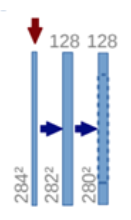

In the constructor of the Encoder class you will pass as parameter a list containing the number of channels used for each encoder block. In the forward function you will return a list containing the outputs of all the encoder blocks (you’ll be using them for the connection between the down-sampling path and the up-sampling path).

You can also use a pre-trained module from torchvision for this. You'll first load the pre-trained weights on ImageNet, and "freeze" these weights during the training process (set required_grad=False for those tensors). The problem is that to create the skip connections required by the U-Net architecture we need access to the feature maps of some intermediate layers in the network and these are not accessible by default.

You should inspect the implementation of the CNN that you chose, make the Encoder class inherit from the model you chose, and in the forward function, return the output of the layers you selected for the skip connections.



## The up-sampling path (Decoder)

In the upsampling path, we'll use transposed convolutions to progressively increase the resolution of the activation maps. The layers for the transposed convolution is [ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html).

Let's write a function to implement an upsampling block, consisting of a transposed convolution, a batch normalization block and a ReLu activation.

Remember, the output size $W_o$ of a transposed convolutional layer is:  
\begin{equation}
W_o = (W_i - 1) \cdot S - 2P + F
\end{equation},

where $W_i$ is the size of the input, $S$ is the stride, $P$ is the amount of padding and $F$ is the filter size.


Similarly to the encoder, the decoder will be composed of several blocks, and each block will consist in a transposed convolution (followed by a batch normalization layer and a ReLU non-linearity) and then by an encoder block.  

 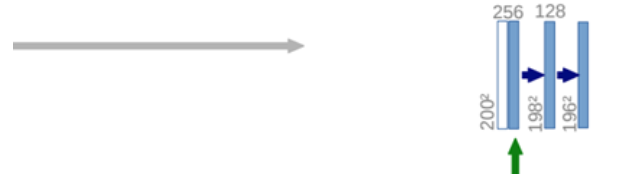

Write a class Decoder  which inherits from ``torch.nn.Module`` to implement the up-samping path; the constructor of this class will get as parameter the depth of each decoder module, and in the forward function you will have two parameters: the input feature map and a list of activations from the encoder (for the skip connections).  



In the forward function, for each block:

- apply the up-sampling operation (followed by batch normalization and ReLU);

- crop the corresponding activation map from the encoder (use CenterCrop) such that is has the same size as the decoder block;

- concatenate these two activation maps (on the channel dimension);

- apply an encoder block on the result;

- pass the result to the next decoder block.



# Simpler implementation

Alternatively, you can choose to implement the entire architecture into a single class.

In the UNet diagram above, the arrows represent the layers in your network.
The blue rectangles represent the feature maps: the number on top of the rectangle is the number of channels of the feature map, while the numbers from the lower left is the spatial shape of the feature map (for example, $572 \times 572$ - is a feature map of height and width $572$)

```
class UNet(torch.nn.Module):
def __init__(num_classes):
    super().__init__()
    # TODO your code here create all the UNET layers
    # enc_11 -> the first convolutional layer from the first encoder block
    # the image is a color image, so the number of channels is 3, while according to the UNet architecture above, the number of output channels is 64
    self.enc_11 = torch.nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3)
    # enc_12 -> the second convolutional layer from the first encoder block
    # 64 input_channels (the input of enc_11 will be the output of enc_11 that has 64 filters),  
    self.enc_12 = torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3)
    # etc etc
   
```

## Putting it all together

Finally, you should write the UNet class which defines the semantic segmentation model. In this class you will use and connect the Encoder and Decoder classes that you previously wrote. The output of the segmentation module will be a volume with as many channels as the number of classes from the segmentation problem. Basically, each channel c from the output will be a map that stores the probability of each pixel to belong to the class c.

Apply a 1x1 convolution with c channels on the decoder output to obtain the segmentation map.

Finally, to have matching shapes between the network output (segmentation map) and the ground truth data, resize the segmentation map using ``torch.nn.functional.interpolate``.


### The training loop


Now, it’s time to write the training loop.  

You remember the steps from the previous labs. You need a train and a test DataLoader and you must first define the loss function cross entropy and select an optimizer.

Then:

- Get a batch of training data from the DataLoader
- Zero out the optimizer’s gradients
- Perform the forward pass
- Calculate and store the loss and the accuracy based on the predictions and the labels from the dataset
- Tell the optimizer to perform one learning step - that is, adjust the model’s learning weights based on the observed gradients for this batch, according to the optimization algorithm we chose
- Evaluate the model on the validation/test set. Store the loss and the accuracy on the validation/test set.

In [13]:
dataset = torchvision.datasets.LFWPairs(root = './', download = False, transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]))

In [24]:
#shape of dataset[0]
dataset[0][2]

1

In [85]:

import os
import random
import torch
import glob
import hashlib
import tarfile
import requests
import cv2
from tqdm import tqdm


class LFWDataset(torch.utils.data.Dataset):
    _DATA = (
        # images
        ("http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz", None),
        # segmentation masks as ppm
        ("https://vis-www.cs.umass.edu/lfw/part_labels/parts_lfw_funneled_gt_images.tgz",
         "3e7e26e801c3081d651c8c2ef3c45cfc"),
    )
    

    def __init__(self, base_folder, transforms, download=True, split_name: str = 'train'):
        super().__init__()
        self.base_folder = base_folder
        # TODO your code here: if necessary download and extract the data

        if download:
            self.download_resources(base_folder)
        self.transforms = transforms
        # load the images and the segmentation masks
        self.X = glob.glob(os.path.join(base_folder, 'lfw_funneled', '*/*'))
        self.Y = glob.glob(os.path.join(base_folder, 'parts_lfw_funneled_gt_images', '*'))
        # only keep the images that have a segmentation mask, file names (without extension) should match those in Y
        self.X = [x for x in self.X if os.path.splitext(os.path.basename(x))[0] in [os.path.splitext(os.path.basename(y))[0] for y in self.Y]]
        # sort the images and masks to ensure that they are aligned
        self.X.sort()
        self.Y.sort()

        print(len(self.X), len(self.Y))
        # raise NotImplementedError("Not implemented yet")

    def __getitem__(self, idx):
        # TODO your code here: return the idx^th sample in the dataset: image, segmentation mask
        # TODO your code here: if necessary apply the transforms
        # read image as RGB, not BGR
        img_idx = cv2.imread(self.X[idx])
        img_idx = cv2.cvtColor(img_idx, cv2.COLOR_BGR2RGB)

        mask_idx = cv2.imread(self.Y[idx])
        mask_idx = cv2.cvtColor(mask_idx, cv2.COLOR_BGR2RGB)
        
        if self.transforms is not None:
            img_idx = self.transforms(img_idx)
            mask_idx = self.transforms(mask_idx)
        return img_idx, mask_idx
        

        # raise NotImplementedError("Not implemented yet")

    def __len__(self):
        # TODO your code here: return the number of samples in the dataset
        return len(self.X)
        # raise NotImplementedError("Not implemented yet")

    def download_resources(self, base_folder):
        if not os.path.exists(base_folder):
            os.makedirs(base_folder)
        self._download_and_extract_archive(url=LFWDataset._DATA[1][0], base_folder=base_folder,
                                           md5=LFWDataset._DATA[1][1])
        self._download_and_extract_archive(url=LFWDataset._DATA[0][0], base_folder=base_folder, md5=None)

    def _download_and_extract_archive(self, url, base_folder, md5) -> None:
        """
          Downloads an archive file from a given URL, saves it to the specified base folder,
          and then extracts its contents to the base folder.

          Args:
          - url (str): The URL from which the archive file needs to be downloaded.
          - base_folder (str): The path where the downloaded archive file will be saved and extracted.
          - md5 (str): The MD5 checksum of the expected archive file for validation.
          """
        base_folder = os.path.expanduser(base_folder)
        filename = os.path.basename(url)

        self._download_url(url, base_folder, md5)
        archive = os.path.join(base_folder, filename)
        print(f"Extracting {archive} to {base_folder}")
        self._extract_tar_archive(archive, base_folder, True)

    def _retreive(self, url, save_location, chunk_size: int = 1024 * 32) -> None:
        """
            Downloads a file from a given URL and saves it to the specified location.

            Args:
            - url (str): The URL from which the file needs to be downloaded.
            - save_location (str): The path where the downloaded file will be saved.
            - chunk_size (int, optional): The size of each chunk of data to be downloaded. Defaults to 32 KB.
            """
        try:
            response = requests.get(url, stream=True)
            total_size = int(response.headers.get('content-length', 0))

            with open(save_location, 'wb') as file, tqdm(
                    desc=os.path.basename(save_location),
                    total=total_size,
                    unit='B',
                    unit_scale=True,
                    unit_divisor=1024,
            ) as bar:
                for data in response.iter_content(chunk_size=chunk_size):
                    file.write(data)
                    bar.update(len(data))

            print(f"Download successful. File saved to: {save_location}")

        except Exception as e:
            print(f"An error occurred: {str(e)}")

    def _download_url(self, url: str, base_folder: str, md5: str = None) -> None:
        """Downloads the file from the url to the specified folder

        Args:
            url (str): URL to download file from
            base_folder (str): Directory to place downloaded file in
            md5 (str, optional): MD5 checksum of the download. If None, do not check
        """
        base_folder = os.path.expanduser(base_folder)
        filename = os.path.basename(url)
        file_path = os.path.join(base_folder, filename)

        os.makedirs(base_folder, exist_ok=True)

        # check if the file already exists
        if self._check_file(file_path, md5):
            print(f"File {file_path} already exists. Using that version")
            return

        print(f"Downloading {url} to file_path")
        self._retreive(url, file_path)

        # check integrity of downloaded file
        if not self._check_file(file_path, md5):
            raise RuntimeError("File not found or corrupted.")

    def _extract_tar_archive(self, from_path: str, to_path: str = None, remove_finished: bool = False) -> str:
        """Extract a tar archive.

        Args:
            from_path (str): Path to the file to be extracted.
            to_path (str): Path to the directory the file will be extracted to. If omitted, the directory of the file is
                used.
            remove_finished (bool): If True , remove the file after the extraction.
        Returns:
            (str): Path to the directory the file was extracted to.
        """
        if to_path is None:
            to_path = os.path.dirname(from_path)

        with tarfile.open(from_path, "r") as tar:
            tar.extractall(to_path)

        if remove_finished:
            os.remove(from_path)
        return to_path

    def _compute_md5(self, filepath: str, chunk_size: int = 1024 * 1024) -> str:
        with open(filepath, "rb") as f:
            md5 = hashlib.md5()
            while chunk := f.read(chunk_size):
                md5.update(chunk)
        return md5.hexdigest()

    def _check_file(self, filepath: str, md5: str) -> bool:
        if not os.path.isfile(filepath):
            return False
        if md5 is None:
            return True
        return self._compute_md5(filepath) == md5
    def dropMost(self):
        self.X = self.X[:100]
        self.Y = self.Y[:100]
    def split_dataset(self, train_ratio=0.7, test_ratio=0.15, valid_ratio=0.15, random_seed=None):
        assert train_ratio + test_ratio + valid_ratio == 1.0, "Ratios should sum to 1.0"

        num_samples = len(self.X)
        indices = list(range(num_samples))

        if random_seed is not None:
            random.seed(random_seed)
            
        random.shuffle(indices)

        train_size = int(train_ratio * num_samples)
        test_size = int(test_ratio * num_samples)

        train_indices = indices[:train_size]
        test_indices = indices[train_size:train_size + test_size]
        valid_indices = indices[train_size + test_size:]

        # Create new datasets for each split
        train_set = LFWDatasetSubset(self, train_indices)
        test_set = LFWDatasetSubset(self, test_indices)
        valid_set = LFWDatasetSubset(self, valid_indices)

        return train_set, test_set, valid_set
class LFWDatasetSubset(torch.utils.data.Dataset):
    def __init__(self, full_dataset, subset_indices):
        self.full_dataset = full_dataset
        self.subset_indices = subset_indices

    def __getitem__(self, idx):
        return self.full_dataset[self.subset_indices[idx]]

    def __len__(self):
        return len(self.subset_indices)
    def dropMost(self):
        self.subset_indices = self.subset_indices[:100]

if __name__ == '__main__':
    # LFWDataset(download=False, base_folder='data/lfw_dataset', transforms=None)
    pass


In [2]:
from torchvision import transforms
bs = 4
transforms = transforms.Compose([transforms.ToPILImage(),
 	transforms.Resize((250,
		250)),
	transforms.ToTensor()])
dataset = LFWDataset(download=False, base_folder='lfw_dataset', transforms=transforms)
dataset.dropMost()
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True, num_workers=0)

2927 2927


In [13]:
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
import torch

class Block(Module):
	def __init__(self, inChannels, outChannels):
		super().__init__()
		# store the convolution and RELU layers
		self.conv1 = Conv2d(inChannels, outChannels, 3)
		self.relu = ReLU()
		self.conv2 = Conv2d(outChannels, outChannels, 3)
	def forward(self, x):
		# apply CONV => RELU => CONV block to the inputs and return it
		return self.conv2(self.relu(self.conv1(x)))

class Encoder(Module):
	def __init__(self, channels=(3, 16, 32, 64)):
		super().__init__()
		# store the encoder blocks and maxpooling layer
		self.encBlocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
		self.pool = MaxPool2d(2)
	def forward(self, x):
		# initialize an empty list to store the intermediate outputs
		blockOutputs = []
		# loop through the encoder blocks
		for block in self.encBlocks:
			# pass the inputs through the current encoder block, store
			# the outputs, and then apply maxpooling on the output
			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)
		# return the list containing the intermediate outputs
		return blockOutputs

class Decoder(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		# initialize the number of channels, upsampler blocks, and
		# decoder blocks
		self.channels = channels
		self.upconvs = ModuleList(
			[ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
			 	for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
	def forward(self, x, encFeatures):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)

			
			# crop the current features from the encoder blocks,
			# concatenate them with the current upsampled features,
			# and pass the concatenated output through the current
			# decoder block
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		# return the final decoder output
		return x
	def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		# return the cropped features
		return encFeatures
	
class UNet(Module):
	def __init__(self, encChannels=(3, 16, 32, 64),
		 decChannels=(64, 32, 16),
		 nbClasses=3, retainDim=True,
		 outSize=(250,  250)):
		super().__init__()
		# initialize the encoder and decoder
		self.encoder = Encoder(encChannels)
		self.decoder = Decoder(decChannels)
		# initialize the regression head and store the class variables
		self.head = Conv2d(decChannels[-1], nbClasses, 1)
		self.retainDim = retainDim
		self.outSize = outSize
	def forward(self, x):
		# grab the features from the encoder
		encFeatures = self.encoder(x)
		# pass the encoder features through decoder making sure that
		# their dimensions are suited for concatenation
		decFeatures = self.decoder(encFeatures[::-1][0],
			encFeatures[::-1][1:])
		# pass the decoder features through the regression head to
		# obtain the segmentation mask
		map = self.head(decFeatures)
		# check to see if we are retaining the original output
		# dimensions and if so, then resize the output to match them
		if self.retainDim:
			map = F.interpolate(map, self.outSize)
		# return the segmentation map
		return map

In [4]:
# import stuff to train
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import time
import os

In [5]:
unet = UNet()
# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=0.0001)
# calculate steps per epoch for training and test set
trainSteps = len(dataset) // bs
# testSteps = len(testDS) // config.BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [6]:
print("[INFO] training the network...")
startTime = time.time()
epochs = 100
for e in tqdm(range(epochs)):
	# set the model in training mode
	unet.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	# loop over the training set
	for (i, (x, y)) in enumerate(dataloader):
		# send the input to the device
		# (x, y) = (x.to("cpu"), y.to("cpu"))
		# perform a forward pass and calculate the training loss
		pred = unet(x)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
	# switch off autograd
	# with torch.no_grad():
	# 	# set the model in evaluation mode
	# 	unet.eval()
	# 	# loop over the validation set
	# 	for (x, y) in testLoader:
	# 		# send the input to the device
	# 		(x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))
	# 		# make the predictions and calculate the validation loss
	# 		pred = unet(x)
	# 		totalTestLoss += lossFunc(pred, y)
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	# avgTestLoss = totalTestLoss / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss)
	# H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, epochs))
	print("Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, 0.0)) #avgTestLoss
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

# export model to file
torch.save(unet.state_dict(), 'unet.pth')
# load model from file
# unet = UNet()
# unet.load_state_dict(torch.load('unet.pth'))

[INFO] training the network...


  1%|          | 1/100 [00:08<13:16,  8.04s/it]

[INFO] EPOCH: 1/100
Train loss: 0.692695, Test loss: 0.0000


  2%|▏         | 2/100 [00:15<13:02,  7.98s/it]

[INFO] EPOCH: 2/100
Train loss: 0.642137, Test loss: 0.0000


  3%|▎         | 3/100 [00:23<12:36,  7.80s/it]

[INFO] EPOCH: 3/100
Train loss: 0.516651, Test loss: 0.0000


  4%|▍         | 4/100 [00:31<12:20,  7.71s/it]

[INFO] EPOCH: 4/100
Train loss: 0.485318, Test loss: 0.0000


  5%|▌         | 5/100 [00:38<12:06,  7.65s/it]

[INFO] EPOCH: 5/100
Train loss: 0.468161, Test loss: 0.0000


  6%|▌         | 6/100 [00:46<11:56,  7.62s/it]

[INFO] EPOCH: 6/100
Train loss: 0.439487, Test loss: 0.0000


  7%|▋         | 7/100 [00:53<11:46,  7.60s/it]

[INFO] EPOCH: 7/100
Train loss: 0.403467, Test loss: 0.0000


  8%|▊         | 8/100 [01:01<11:38,  7.59s/it]

[INFO] EPOCH: 8/100
Train loss: 0.380434, Test loss: 0.0000


  9%|▉         | 9/100 [01:09<11:38,  7.67s/it]

[INFO] EPOCH: 9/100
Train loss: 0.370171, Test loss: 0.0000


 10%|█         | 10/100 [01:17<11:34,  7.71s/it]

[INFO] EPOCH: 10/100
Train loss: 0.363504, Test loss: 0.0000


 11%|█         | 11/100 [01:24<11:22,  7.67s/it]

[INFO] EPOCH: 11/100
Train loss: 0.358094, Test loss: 0.0000


 12%|█▏        | 12/100 [01:32<11:12,  7.65s/it]

[INFO] EPOCH: 12/100
Train loss: 0.350550, Test loss: 0.0000


 13%|█▎        | 13/100 [01:39<11:02,  7.61s/it]

[INFO] EPOCH: 13/100
Train loss: 0.344152, Test loss: 0.0000


 14%|█▍        | 14/100 [01:47<10:53,  7.59s/it]

[INFO] EPOCH: 14/100
Train loss: 0.334043, Test loss: 0.0000


 15%|█▌        | 15/100 [01:54<10:44,  7.58s/it]

[INFO] EPOCH: 15/100
Train loss: 0.325486, Test loss: 0.0000


 16%|█▌        | 16/100 [02:02<10:36,  7.57s/it]

[INFO] EPOCH: 16/100
Train loss: 0.312970, Test loss: 0.0000


 17%|█▋        | 17/100 [02:10<10:29,  7.59s/it]

[INFO] EPOCH: 17/100
Train loss: 0.314376, Test loss: 0.0000


 18%|█▊        | 18/100 [02:17<10:22,  7.59s/it]

[INFO] EPOCH: 18/100
Train loss: 0.306199, Test loss: 0.0000


 19%|█▉        | 19/100 [02:25<10:14,  7.59s/it]

[INFO] EPOCH: 19/100
Train loss: 0.303171, Test loss: 0.0000


 20%|██        | 20/100 [02:32<10:07,  7.60s/it]

[INFO] EPOCH: 20/100
Train loss: 0.300223, Test loss: 0.0000


 21%|██        | 21/100 [02:40<10:00,  7.61s/it]

[INFO] EPOCH: 21/100
Train loss: 0.299929, Test loss: 0.0000


 22%|██▏       | 22/100 [02:48<09:52,  7.60s/it]

[INFO] EPOCH: 22/100
Train loss: 0.297146, Test loss: 0.0000


 23%|██▎       | 23/100 [02:55<09:45,  7.61s/it]

[INFO] EPOCH: 23/100
Train loss: 0.296708, Test loss: 0.0000


 24%|██▍       | 24/100 [03:03<09:37,  7.60s/it]

[INFO] EPOCH: 24/100
Train loss: 0.304306, Test loss: 0.0000


 25%|██▌       | 25/100 [03:10<09:29,  7.60s/it]

[INFO] EPOCH: 25/100
Train loss: 0.298746, Test loss: 0.0000


 26%|██▌       | 26/100 [03:18<09:22,  7.60s/it]

[INFO] EPOCH: 26/100
Train loss: 0.293889, Test loss: 0.0000


 27%|██▋       | 27/100 [03:25<09:14,  7.59s/it]

[INFO] EPOCH: 27/100
Train loss: 0.291888, Test loss: 0.0000


 28%|██▊       | 28/100 [03:33<09:06,  7.59s/it]

[INFO] EPOCH: 28/100
Train loss: 0.290669, Test loss: 0.0000


 29%|██▉       | 29/100 [03:41<08:58,  7.58s/it]

[INFO] EPOCH: 29/100
Train loss: 0.292257, Test loss: 0.0000


 30%|███       | 30/100 [03:48<08:51,  7.59s/it]

[INFO] EPOCH: 30/100
Train loss: 0.290446, Test loss: 0.0000


 31%|███       | 31/100 [03:56<08:43,  7.59s/it]

[INFO] EPOCH: 31/100
Train loss: 0.289874, Test loss: 0.0000


 32%|███▏      | 32/100 [04:03<08:36,  7.59s/it]

[INFO] EPOCH: 32/100
Train loss: 0.286450, Test loss: 0.0000


 33%|███▎      | 33/100 [04:11<08:28,  7.58s/it]

[INFO] EPOCH: 33/100
Train loss: 0.287338, Test loss: 0.0000


 34%|███▍      | 34/100 [04:19<08:20,  7.59s/it]

[INFO] EPOCH: 34/100
Train loss: 0.285475, Test loss: 0.0000


 35%|███▌      | 35/100 [04:26<08:13,  7.59s/it]

[INFO] EPOCH: 35/100
Train loss: 0.286554, Test loss: 0.0000


 36%|███▌      | 36/100 [04:34<08:04,  7.58s/it]

[INFO] EPOCH: 36/100
Train loss: 0.280537, Test loss: 0.0000


 37%|███▋      | 37/100 [04:41<07:57,  7.57s/it]

[INFO] EPOCH: 37/100
Train loss: 0.281837, Test loss: 0.0000


 38%|███▊      | 38/100 [04:49<07:50,  7.58s/it]

[INFO] EPOCH: 38/100
Train loss: 0.287128, Test loss: 0.0000


 39%|███▉      | 39/100 [04:57<07:43,  7.60s/it]

[INFO] EPOCH: 39/100
Train loss: 0.286258, Test loss: 0.0000


 40%|████      | 40/100 [05:04<07:35,  7.60s/it]

[INFO] EPOCH: 40/100
Train loss: 0.284350, Test loss: 0.0000


 41%|████      | 41/100 [05:12<07:29,  7.63s/it]

[INFO] EPOCH: 41/100
Train loss: 0.283077, Test loss: 0.0000


 42%|████▏     | 42/100 [05:19<07:22,  7.63s/it]

[INFO] EPOCH: 42/100
Train loss: 0.275065, Test loss: 0.0000


 43%|████▎     | 43/100 [05:27<07:14,  7.62s/it]

[INFO] EPOCH: 43/100
Train loss: 0.281857, Test loss: 0.0000


 44%|████▍     | 44/100 [05:35<07:06,  7.62s/it]

[INFO] EPOCH: 44/100
Train loss: 0.277700, Test loss: 0.0000


 45%|████▌     | 45/100 [05:42<06:58,  7.61s/it]

[INFO] EPOCH: 45/100
Train loss: 0.273235, Test loss: 0.0000


 46%|████▌     | 46/100 [05:50<06:51,  7.61s/it]

[INFO] EPOCH: 46/100
Train loss: 0.277313, Test loss: 0.0000


 47%|████▋     | 47/100 [05:58<06:43,  7.61s/it]

[INFO] EPOCH: 47/100
Train loss: 0.275693, Test loss: 0.0000


 48%|████▊     | 48/100 [06:05<06:35,  7.61s/it]

[INFO] EPOCH: 48/100
Train loss: 0.273733, Test loss: 0.0000


 49%|████▉     | 49/100 [06:13<06:27,  7.61s/it]

[INFO] EPOCH: 49/100
Train loss: 0.272411, Test loss: 0.0000


 50%|█████     | 50/100 [06:20<06:19,  7.60s/it]

[INFO] EPOCH: 50/100
Train loss: 0.272455, Test loss: 0.0000


 51%|█████     | 51/100 [06:28<06:12,  7.60s/it]

[INFO] EPOCH: 51/100
Train loss: 0.268432, Test loss: 0.0000


 52%|█████▏    | 52/100 [06:35<06:04,  7.60s/it]

[INFO] EPOCH: 52/100
Train loss: 0.268921, Test loss: 0.0000


 53%|█████▎    | 53/100 [06:43<05:57,  7.60s/it]

[INFO] EPOCH: 53/100
Train loss: 0.269900, Test loss: 0.0000


 54%|█████▍    | 54/100 [06:51<05:50,  7.62s/it]

[INFO] EPOCH: 54/100
Train loss: 0.272513, Test loss: 0.0000


 55%|█████▌    | 55/100 [06:58<05:43,  7.63s/it]

[INFO] EPOCH: 55/100
Train loss: 0.265483, Test loss: 0.0000


 56%|█████▌    | 56/100 [07:06<05:35,  7.63s/it]

[INFO] EPOCH: 56/100
Train loss: 0.268707, Test loss: 0.0000


 57%|█████▋    | 57/100 [07:14<05:27,  7.62s/it]

[INFO] EPOCH: 57/100
Train loss: 0.263123, Test loss: 0.0000


 58%|█████▊    | 58/100 [07:21<05:20,  7.63s/it]

[INFO] EPOCH: 58/100
Train loss: 0.260896, Test loss: 0.0000


 59%|█████▉    | 59/100 [07:29<05:13,  7.64s/it]

[INFO] EPOCH: 59/100
Train loss: 0.260031, Test loss: 0.0000


 60%|██████    | 60/100 [07:37<05:05,  7.64s/it]

[INFO] EPOCH: 60/100
Train loss: 0.262616, Test loss: 0.0000


 61%|██████    | 61/100 [07:44<04:57,  7.63s/it]

[INFO] EPOCH: 61/100
Train loss: 0.263675, Test loss: 0.0000


 62%|██████▏   | 62/100 [07:52<04:50,  7.65s/it]

[INFO] EPOCH: 62/100
Train loss: 0.273247, Test loss: 0.0000


 63%|██████▎   | 63/100 [08:00<04:42,  7.64s/it]

[INFO] EPOCH: 63/100
Train loss: 0.262583, Test loss: 0.0000


 64%|██████▍   | 64/100 [08:07<04:34,  7.62s/it]

[INFO] EPOCH: 64/100
Train loss: 0.260584, Test loss: 0.0000


 65%|██████▌   | 65/100 [08:15<04:27,  7.63s/it]

[INFO] EPOCH: 65/100
Train loss: 0.262913, Test loss: 0.0000


 66%|██████▌   | 66/100 [08:23<04:21,  7.68s/it]

[INFO] EPOCH: 66/100
Train loss: 0.257875, Test loss: 0.0000


 67%|██████▋   | 67/100 [08:30<04:14,  7.72s/it]

[INFO] EPOCH: 67/100
Train loss: 0.259068, Test loss: 0.0000


 68%|██████▊   | 68/100 [08:38<04:06,  7.69s/it]

[INFO] EPOCH: 68/100
Train loss: 0.254052, Test loss: 0.0000


 69%|██████▉   | 69/100 [08:45<03:56,  7.64s/it]

[INFO] EPOCH: 69/100
Train loss: 0.256813, Test loss: 0.0000


 70%|███████   | 70/100 [08:53<03:48,  7.61s/it]

[INFO] EPOCH: 70/100
Train loss: 0.252764, Test loss: 0.0000


 71%|███████   | 71/100 [09:01<03:40,  7.59s/it]

[INFO] EPOCH: 71/100
Train loss: 0.250440, Test loss: 0.0000


 72%|███████▏  | 72/100 [09:08<03:31,  7.56s/it]

[INFO] EPOCH: 72/100
Train loss: 0.251177, Test loss: 0.0000


 73%|███████▎  | 73/100 [09:16<03:23,  7.55s/it]

[INFO] EPOCH: 73/100
Train loss: 0.247953, Test loss: 0.0000


 74%|███████▍  | 74/100 [09:23<03:16,  7.55s/it]

[INFO] EPOCH: 74/100
Train loss: 0.252185, Test loss: 0.0000


 75%|███████▌  | 75/100 [09:31<03:08,  7.53s/it]

[INFO] EPOCH: 75/100
Train loss: 0.263045, Test loss: 0.0000


 76%|███████▌  | 76/100 [09:38<03:00,  7.53s/it]

[INFO] EPOCH: 76/100
Train loss: 0.260850, Test loss: 0.0000


 77%|███████▋  | 77/100 [09:46<02:53,  7.53s/it]

[INFO] EPOCH: 77/100
Train loss: 0.254323, Test loss: 0.0000


 78%|███████▊  | 78/100 [09:54<02:48,  7.67s/it]

[INFO] EPOCH: 78/100
Train loss: 0.249372, Test loss: 0.0000


 79%|███████▉  | 79/100 [10:01<02:41,  7.68s/it]

[INFO] EPOCH: 79/100
Train loss: 0.250019, Test loss: 0.0000


 80%|████████  | 80/100 [10:09<02:34,  7.73s/it]

[INFO] EPOCH: 80/100
Train loss: 0.252450, Test loss: 0.0000


 81%|████████  | 81/100 [10:17<02:26,  7.69s/it]

[INFO] EPOCH: 81/100
Train loss: 0.247987, Test loss: 0.0000


 82%|████████▏ | 82/100 [10:24<02:17,  7.66s/it]

[INFO] EPOCH: 82/100
Train loss: 0.245281, Test loss: 0.0000


 83%|████████▎ | 83/100 [10:32<02:09,  7.64s/it]

[INFO] EPOCH: 83/100
Train loss: 0.245246, Test loss: 0.0000


 84%|████████▍ | 84/100 [10:40<02:01,  7.61s/it]

[INFO] EPOCH: 84/100
Train loss: 0.243514, Test loss: 0.0000


 85%|████████▌ | 85/100 [10:47<01:53,  7.59s/it]

[INFO] EPOCH: 85/100
Train loss: 0.252720, Test loss: 0.0000


 86%|████████▌ | 86/100 [10:55<01:45,  7.57s/it]

[INFO] EPOCH: 86/100
Train loss: 0.246595, Test loss: 0.0000


 87%|████████▋ | 87/100 [11:02<01:38,  7.57s/it]

[INFO] EPOCH: 87/100
Train loss: 0.248684, Test loss: 0.0000


 88%|████████▊ | 88/100 [11:10<01:30,  7.56s/it]

[INFO] EPOCH: 88/100
Train loss: 0.243498, Test loss: 0.0000


 89%|████████▉ | 89/100 [11:17<01:23,  7.55s/it]

[INFO] EPOCH: 89/100
Train loss: 0.243597, Test loss: 0.0000


 90%|█████████ | 90/100 [11:25<01:15,  7.56s/it]

[INFO] EPOCH: 90/100
Train loss: 0.242671, Test loss: 0.0000


 91%|█████████ | 91/100 [11:32<01:08,  7.56s/it]

[INFO] EPOCH: 91/100
Train loss: 0.243051, Test loss: 0.0000


 92%|█████████▏| 92/100 [11:40<01:00,  7.57s/it]

[INFO] EPOCH: 92/100
Train loss: 0.258352, Test loss: 0.0000


 93%|█████████▎| 93/100 [11:48<00:53,  7.58s/it]

[INFO] EPOCH: 93/100
Train loss: 0.247659, Test loss: 0.0000


 94%|█████████▍| 94/100 [11:55<00:45,  7.56s/it]

[INFO] EPOCH: 94/100
Train loss: 0.247806, Test loss: 0.0000


 95%|█████████▌| 95/100 [12:03<00:37,  7.55s/it]

[INFO] EPOCH: 95/100
Train loss: 0.242973, Test loss: 0.0000


 96%|█████████▌| 96/100 [12:10<00:30,  7.56s/it]

[INFO] EPOCH: 96/100
Train loss: 0.244180, Test loss: 0.0000


 97%|█████████▋| 97/100 [12:18<00:22,  7.56s/it]

[INFO] EPOCH: 97/100
Train loss: 0.240292, Test loss: 0.0000


 98%|█████████▊| 98/100 [12:25<00:15,  7.55s/it]

[INFO] EPOCH: 98/100
Train loss: 0.251711, Test loss: 0.0000


 99%|█████████▉| 99/100 [12:33<00:07,  7.62s/it]

[INFO] EPOCH: 99/100
Train loss: 0.245892, Test loss: 0.0000


100%|██████████| 100/100 [12:41<00:00,  7.61s/it]

[INFO] EPOCH: 100/100
Train loss: 0.241539, Test loss: 0.0000
[INFO] total time taken to train the model: 761.50s


Am incercat sa il pun si pe colab pt gpu, se umplea RAM si nu VRAM (chiar daca le trimiteam pe device, modelul si datele). In final local a rulat cel putin.

## Evaluation metrics

Finally, you will implement several segmentation metrics to evaluate the model you've just trained. As usual, try to implement these metrics without using any for loops.

In the remainder of this section we'll use the following notation:
- $n_{ij}$ - the total number of pixels classified to class
j but actually belonging to class i; $i, j \in 1, .., C$;
- $t_i = \sum_{j = 1}^{C} n_{ij}$ - the total number of pixels belonging to class $i$ (in the ground truth segmentation mask);
- $C$ - the total number of classes in the segmentation problem.

### Mean pixel accuracy

Pixel accuracy is the simplest image segmentation metric; it is defined as the percentage of pixels that were correctly classified by the model.

\begin{equation}
p_a = \frac{1}{C} \frac{\sum_{i}^{C} n_{ii}}{\sum_{i}^{C} t_i}
\end{equation}

This metric is not that relevant for class imbalanced problems (which occurs for most segmentation problems).

### Intersection over Union (IoU)

the intersection over union metric is defined as the ratio between the area of intersection and the area of union (between the predicted segmentation mask and the ground truth segmentation mask of a single class).
In case of a multi-class segmentation problem, we simple average the IoUs over all the classes. This metric is called mean Intersection over Union (mIou).

\begin{equation}
mIoU = \frac{1}{C} \sum_{i = 1}^{C} \frac{n_{ii}}{t_i - n_{ii} + \sum_{j = 1}^{C} n_{ji}}
\end{equation}

The ideal value for this metric is 1; usually values lower than 0.6 indicate a very bad performance.

### Frequency Weighted Intersection over Union

The frequency weighted over union metric is similar to mean IoU, but the values are weighted with the adequate frequencies of the pixels.

\begin{equation}
fIou = (\sum_{i = 1}^{k} t_i)^{-1}   \sum_{i = 1}^{C} t_i \cdot \frac{n_{ii}}{t_i - n_{ii} + \sum_{j = 1}^{C} n_{ji}}
\end{equation}

The values of this metric lie in the interval [0, 1], and the ideal value for this metric is 1.

Compute and report these metrics for your trained model(s).



In [14]:
from torchvision import transforms
bs = 4
transforms = transforms.Compose([transforms.ToPILImage(),
 	transforms.Resize((250,
		250)),
	transforms.ToTensor()])
testDataset = LFWDataset(download=False, base_folder='lfw_dataset', transforms=transforms)
testLoader = DataLoader(testDataset, batch_size=bs, shuffle=True, num_workers=0)

2927 2927


In [74]:
preds = []
masks = []
# switch off autograd
with torch.no_grad():
    # set the model in evaluation mode
    unet.eval()
    # loop over the test set
    for (i,(x, y)) in enumerate(testLoader):
        # send the input to the device
        # (x, y) = (x.to("cpu"), y.to("cpu"))
        # make the predictions and add them to the list of predictions
        # and ground-truths
        # preds.append(unet(x).cpu().detach().numpy())
        # masks.append(y.cpu().detach().numpy())  
        for item in x:
            toAdd = item.unsqueeze(0)
            toAdd = unet(toAdd).cpu().detach().numpy()
            # all values > 0 are 1, rest are 0
            toAdd[toAdd > 0] = 1
            toAdd[toAdd <= 0] = 0
            preds.append(toAdd)
        for item in y:
            masks.append(item.cpu().detach().numpy())

In [81]:
import numpy as np
# mean pixel accuracy
def meanPixelAccuracy(outputs, labels):
    correct = 0
    total = 0
    for (output, label) in zip(outputs, labels):
        # convert output to numpy array (3,250,250)
        output = output[0]
        # calculate number of pixels where output and label are equal
        correct += np.sum(output == label)
    total = len(labels) * 250 * 250 * 3

    return correct/total

#intersection over union
def intersectionOverUnion(preds, masks, smooth=1e-6):
    # initialize the list of IoUs
    ious = []
    # loop over the predictions and masks
    for (pred, mask) in zip(preds, masks):
        pred = pred[0]
        intersection = np.sum((pred == 1) & (mask == 1))
        union = np.sum((pred == 1) | (mask == 1))
        # calculate the intersection over union
        iou = (intersection + smooth) / (union + smooth)
        # add the iou to the list of ious
        ious.append(iou)
    # return the average iou
    return sum(ious) / len(ious)
# def frequency weighted intersection over union
def frequencyWeightedIoU(preds, masks, smooth=1e-6):
    # initialize the list of IoUs
    ious = []
    # loop over the predictions and masks
    for (pred, mask) in zip(preds, masks):
        pred = pred[0]
        scores = []
        for channel in range(3):

            intersection = np.sum((pred[channel] == 1) & (mask[channel] == 1))
            union = np.sum((pred[channel] == 1) | (mask[channel] == 1))
            # calculate the intersection over union
            iou = (intersection + smooth) / (union + smooth)
            freq = np.sum(mask[channel] == 1) / np.sum(mask[channel] == 0)
            scores.append(iou * freq)
        # calculate the average score across all channels
        freq_weights = sum(scores) / len(scores)

        # multiply the iou with the frequency weights and add it to
        # the list of ious
        ious.append(freq_weights)

    # return the average weighted IoU
    return sum(ious) / len(ious)



# calculate the 3 metrics
# print(len(preds), len(masks))
# for item in preds:
#     print(item.shape)
# for item in masks:
#     print(item.shape)
acc = meanPixelAccuracy(preds, masks)
iou = intersectionOverUnion(preds, masks)
fwIoU = frequencyWeightedIoU(preds, masks)
# # print the metrics
print("Mean pixel accuracy: {:.4f}".format(acc))
print("Intersection over union: {:.4f}".format(iou))
print("Frequency weighted IoU: {:.4f}".format(fwIoU))

Mean pixel accuracy: 0.8816
Intersection over union: 0.7024
Frequency weighted IoU: 0.7208


# Wandb


This time you will use [wandb](https://wandb.ai/) to track your experiments and perform hyperparameter search.


1. Log the loss and several metrics after each epoch: use ``wandb.log()`` method within your training loop after each epoch to log the loss and at least two metrics on the train and the validation dataset.


2. Use a ``wandb.Table`` to visualize the predictions on the validation dataset across the training process. You can find more details [here](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/datasets-predictions/W%26B_Tables_Quickstart.ipynb#scrollTo=tbOiat0mrWA2).


3. [Artifacts](https://docs.wandb.ai/guides/artifacts/construct-an-artifact) are used to track and version any serialized data as the inputs and outputs.


"W&B Artifacts was designed to make it effortless to version your datasets and models, regardless of whether you want to store your files with W&B or whether you already have a bucket you want W&B to track. Once you've tracked your datasets or model files, W&B will automatically log each and every modification, giving you a complete and auditable history of changes to your files."


Create a class ModelCheckpoint which will be responsible for tracking the best N checkpoints across the training process. This class will monitor a metric, and if the value for that metric is higher/lower (depending on whether the ) than the current max/min, it will save a checkpoint of the model.
Also, you should ensure that at a given time only N checkpoints are being saved. So, if the number of saved checkpoints is greater than N, you should perform a cleanup.


```
    def __call__(self, model, epoch, metric_val):
        must_save = metric_val < self.best_metric_val if self.decreasing_metric else metric_val > self.best_metric_val
        if must_save:
            self.best_metric_val = metric_val
            # TODO use torch.save to save the model
            # TODO use the function below to log the model artifact
       
        # TODO if needed, perform cleanup
   
    def write_artifact(self, path, model_path, metric_val):
        artifact = wandb.Artifact(filename, type='model', metadata={'metric': metric_val})
        artifact.add_file(model_path)
        wandb.run.log_artifact(artifact)    


```


4. You will also use [wandb sweeps](https://docs.wandb.ai/guides/sweeps) to automate hyperparameter tuning. This module explores different combinations of hyperparameters to help users find the best configuration for their models.

[Here](https://www.youtube.com/watch?v=9zrmUIlScdY&ab_channel=Weights%26Biases) you can find a video tutorial on how you can use sweeps in wandb and [here](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch/Organizing_Hyperparameter_Sweeps_in_PyTorch_with_W%26B.ipynb) the corresponding colab.


Random Search is a hyperparameter optimization technique that involves randomly sampling hyperparameter values within specified ranges or distributions. It explores the hyperparameter space by selecting combinations randomly, allowing for a broad search across various configurations without following a specific pattern or grid.


Grid Search is a method where hyperparameter values are exhaustively tested across a predefined grid or set of values. It evaluates the model's performance for each combination of hyperparameters within the specified ranges, systematically covering the entire search space to find the optimal configuration.


Perform hyperparameter search using wandb sweeps (more details [here](https://wandb.ai/wandb_fc/articles/reports/Running-Hyperparameter-Sweeps-to-Pick-the-Best-Model--Vmlldzo1NDQ0OTIy)) for the learning rate and at least one other parameter.
- first perform a random search as a preliminary exploration to identify "promising" values for your hyperparameters;
- then apply a grid search on this range, to perform a more focused investigation into promising regions for finer optimization.



In [100]:
lfw_dataset = LFWDataset(download=False, base_folder='lfw_dataset', transforms=transforms)
train_set, test_set, valid_set = lfw_dataset.split_dataset()
train_set.dropMost()
test_set.dropMost()
valid_set.dropMost()

2927 2927


In [101]:
trainLoader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=0)
testLoader = DataLoader(test_set, batch_size=bs, shuffle=True, num_workers=0)
validLoader = DataLoader(valid_set, batch_size=bs, shuffle=True, num_workers=0)

In [116]:
import wandb
wandb.init(project="Lab5", name="RunX2")

wandb: Currently logged in as: deepsmeag. Use `wandb login --relogin` to force relogin


In [112]:
def visualize_predictions(model, val_loader, epoch):
    # ... (prediction and visualization logic)
    prediction_data = []
    preds = []
    masks = []
    for (i,(x, y)) in enumerate(val_loader):
        # send the input to the device
        # (x, y) = (x.to("cpu"), y.to("cpu"))
        
        for item in x:
            toAdd = item.unsqueeze(0)
            toAdd = unet(toAdd).cpu().detach().numpy()
            # all values > 0 are 1, rest are 0
            toAdd[toAdd > 0] = 1
            toAdd[toAdd <= 0] = 0
            preds.append(toAdd)
        for item in y:
            masks.append(item.cpu().detach().numpy())
    
    # put in prediction_data the image index and its mPixelAcc
    for i in range(len(preds)):
        prediction_data.append([i, meanPixelAccuracy(preds[i], masks[i])])
            
    # Log predictions using wandb
    table = wandb.Table(data=prediction_data, columns=["Image Index", "mPixelAcc"])
    wandb.log({"predictions": table}, step=epoch)

In [117]:
import wandb
import torch

class ModelCheckpoint:
    def __init__(self, max_checkpoints, decreasing_metric=True):
        self.max_checkpoints = max_checkpoints
        self.decreasing_metric = decreasing_metric
        self.best_metric_val = float('inf') if decreasing_metric else float('-inf')
        self.saved_checkpoints = []

    def __call__(self, model, epoch, metric_val):
        must_save = metric_val < self.best_metric_val if self.decreasing_metric else metric_val > self.best_metric_val
        if must_save:
            self.best_metric_val = metric_val
            # TODO use torch.save to save the model
            # TODO use the function below to log the model artifact
       
        # TODO if needed, perform cleanup
   
    def write_artifact(self, path, model_path, metric_val):
        artifact = wandb.Artifact("file.pt", type='model', metadata={'metric': metric_val})
        artifact.add_file(model_path)
        wandb.run.log_artifact(artifact)   

    def cleanup_checkpoints(self):
        if len(self.saved_checkpoints) >= self.max_checkpoints:
            # Delete the oldest checkpoint
            oldest_checkpoint = self.saved_checkpoints.pop(0)
            os.remove(oldest_checkpoint)


In [118]:
print("[INFO] training the network...")
startTime = time.time()
epochs = 10
checkPoint = ModelCheckpoint(10)
for e in tqdm(range(epochs)):
	# set the model in training mode
	unet.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	mpa = 0
	# loop over the training set
	for (i, (x, y)) in enumerate(dataloader):
		# send the input to the device
		# (x, y) = (x.to("cpu"), y.to("cpu"))
		# perform a forward pass and calculate the training loss
		pred = unet(x)
		loss = lossFunc(pred, y)
		mpa += meanPixelAccuracy(pred[0].unsqueeze(0).cpu().detach().numpy(), y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
		# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
		# loop over the validation set
		for (i, (x, y)) in enumerate(testLoader):
			# send the input to the device
			# (x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))
			# make the predictions and calculate the validation loss
			pred = unet(x)

			totalTestLoss += lossFunc(pred, y)
		
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / 100
	avgTestLoss = totalTestLoss / 100
	wandb.log({"train_loss": avgTrainLoss, "test_loss": avgTestLoss, "meanPixelAcc": mpa * 4 / 100}, step=e)
	# update our training history
	H["train_loss"].append(avgTrainLoss)
	H["test_loss"].append(avgTestLoss)
	if(e % 5 == 0):
		checkPoint(unet, e, avgTestLoss)
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, epochs))
	print("Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, 0.0)) #avgTestLoss
	visualize_predictions(unet, validLoader, e)
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))
wandb.finish()
# export model to file
# torch.save(unet.state_dict(), 'unet.pth')
# load model from file
# unet = UNet()
# unet.load_state_dict(torch.load('unet.pth'))

[INFO] training the network...


  0%|          | 0/10 [00:00<?, ?it/s]

[INFO] EPOCH: 1/10
Train loss: 0.058194, Test loss: 0.0000


 10%|█         | 1/10 [00:13<02:01, 13.53s/it]

[INFO] EPOCH: 2/10
Train loss: 0.058805, Test loss: 0.0000


 20%|██        | 2/10 [00:26<01:46, 13.30s/it]

[INFO] EPOCH: 3/10
Train loss: 0.058060, Test loss: 0.0000


 30%|███       | 3/10 [00:39<01:31, 13.08s/it]

[INFO] EPOCH: 4/10
Train loss: 0.058419, Test loss: 0.0000


 40%|████      | 4/10 [00:52<01:17, 12.94s/it]

[INFO] EPOCH: 5/10
Train loss: 0.058370, Test loss: 0.0000


 50%|█████     | 5/10 [01:04<01:04, 12.88s/it]

[INFO] EPOCH: 6/10
Train loss: 0.058203, Test loss: 0.0000


 60%|██████    | 6/10 [01:18<00:52, 13.11s/it]

[INFO] EPOCH: 7/10
Train loss: 0.059625, Test loss: 0.0000


 70%|███████   | 7/10 [01:32<00:39, 13.23s/it]

[INFO] EPOCH: 8/10
Train loss: 0.060572, Test loss: 0.0000


 80%|████████  | 8/10 [01:46<00:27, 13.58s/it]

[INFO] EPOCH: 9/10
Train loss: 0.057785, Test loss: 0.0000


 90%|█████████ | 9/10 [02:00<00:13, 13.74s/it]

[INFO] EPOCH: 10/10
Train loss: 0.057628, Test loss: 0.0000


100%|██████████| 10/10 [02:14<00:00, 13.48s/it]


[INFO] total time taken to train the model: 134.82s


meanPixelAcc,▁▁▁▁▁▁▁▁▁▁
test_loss,▁▂▁▁▄▂█▁▂▂
train_loss,▂▄▂▃▃▂▆█▁▁
meanPixelAcc,0.0
test_loss,0.06941
train_loss,0.05763


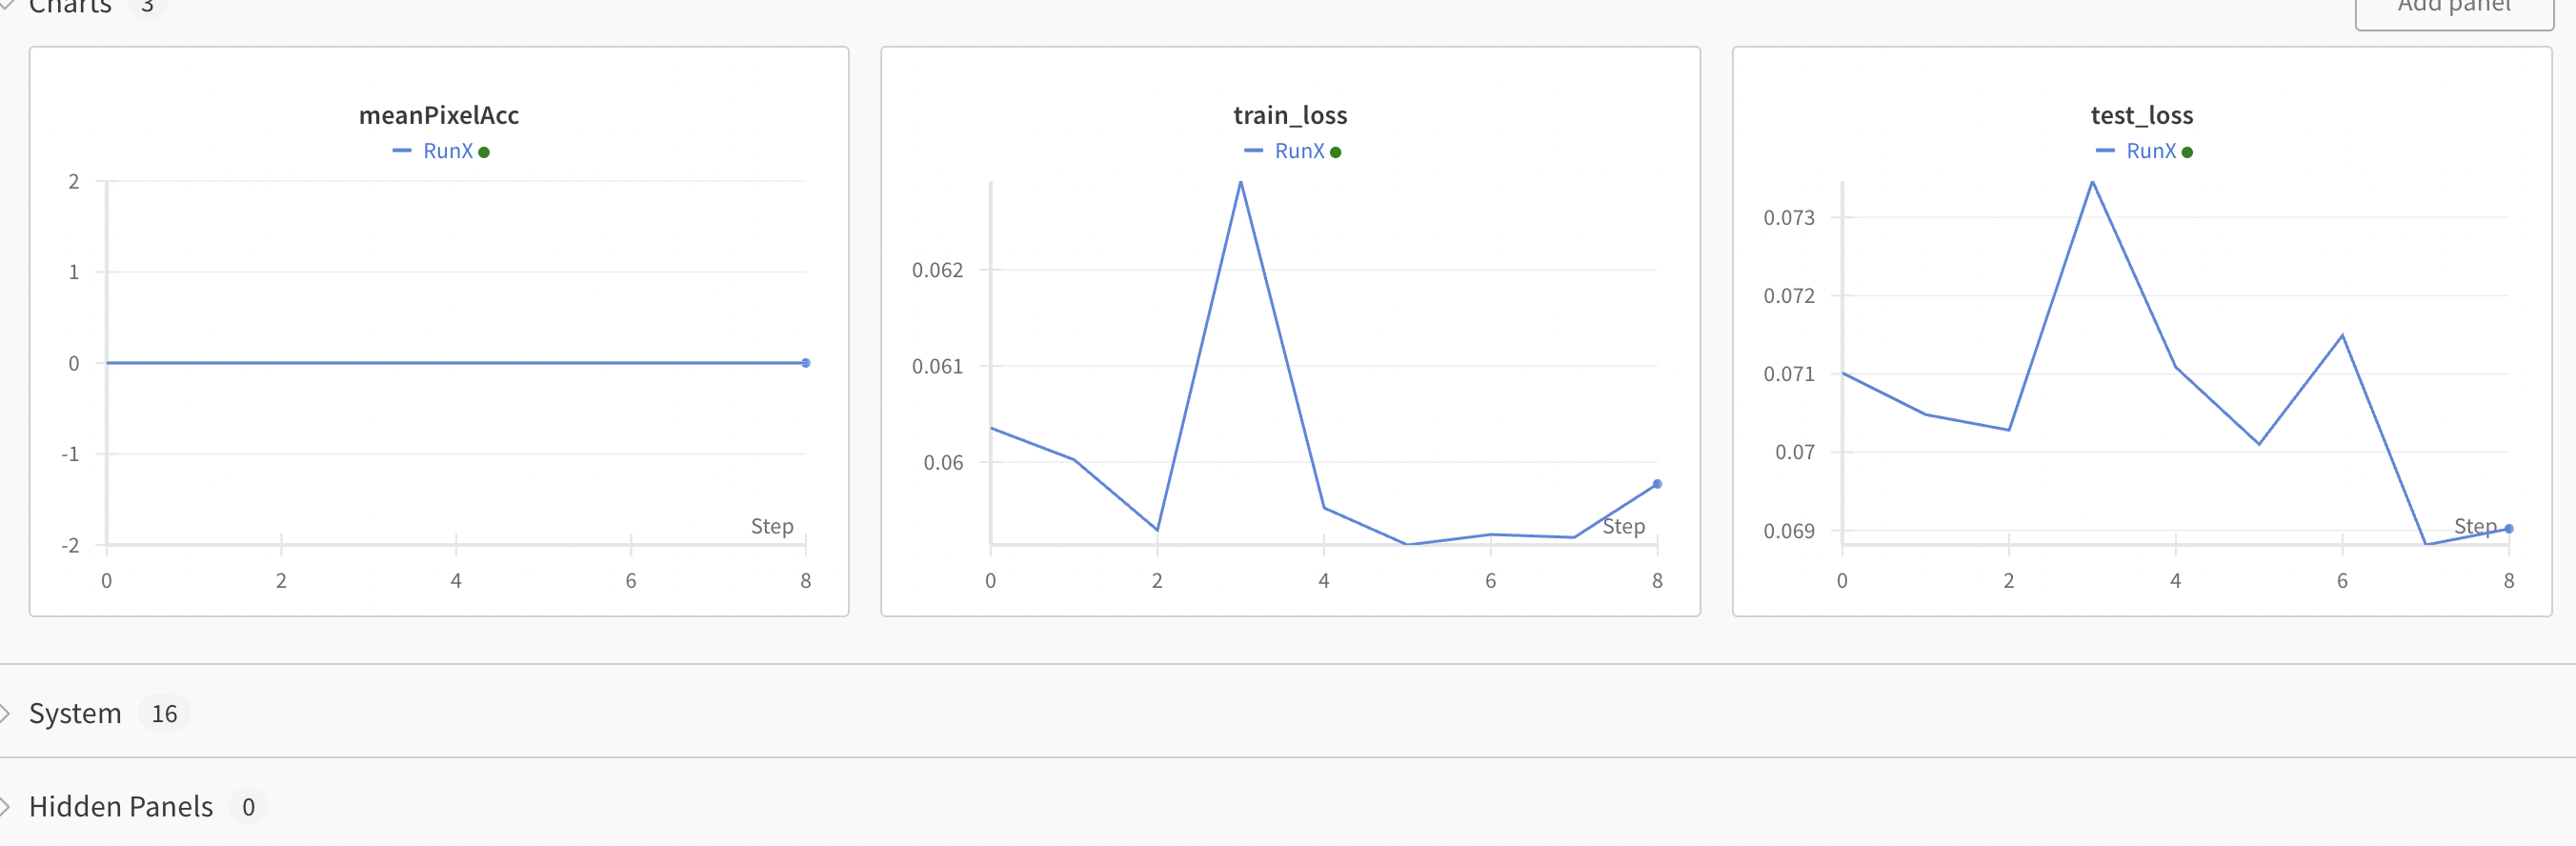

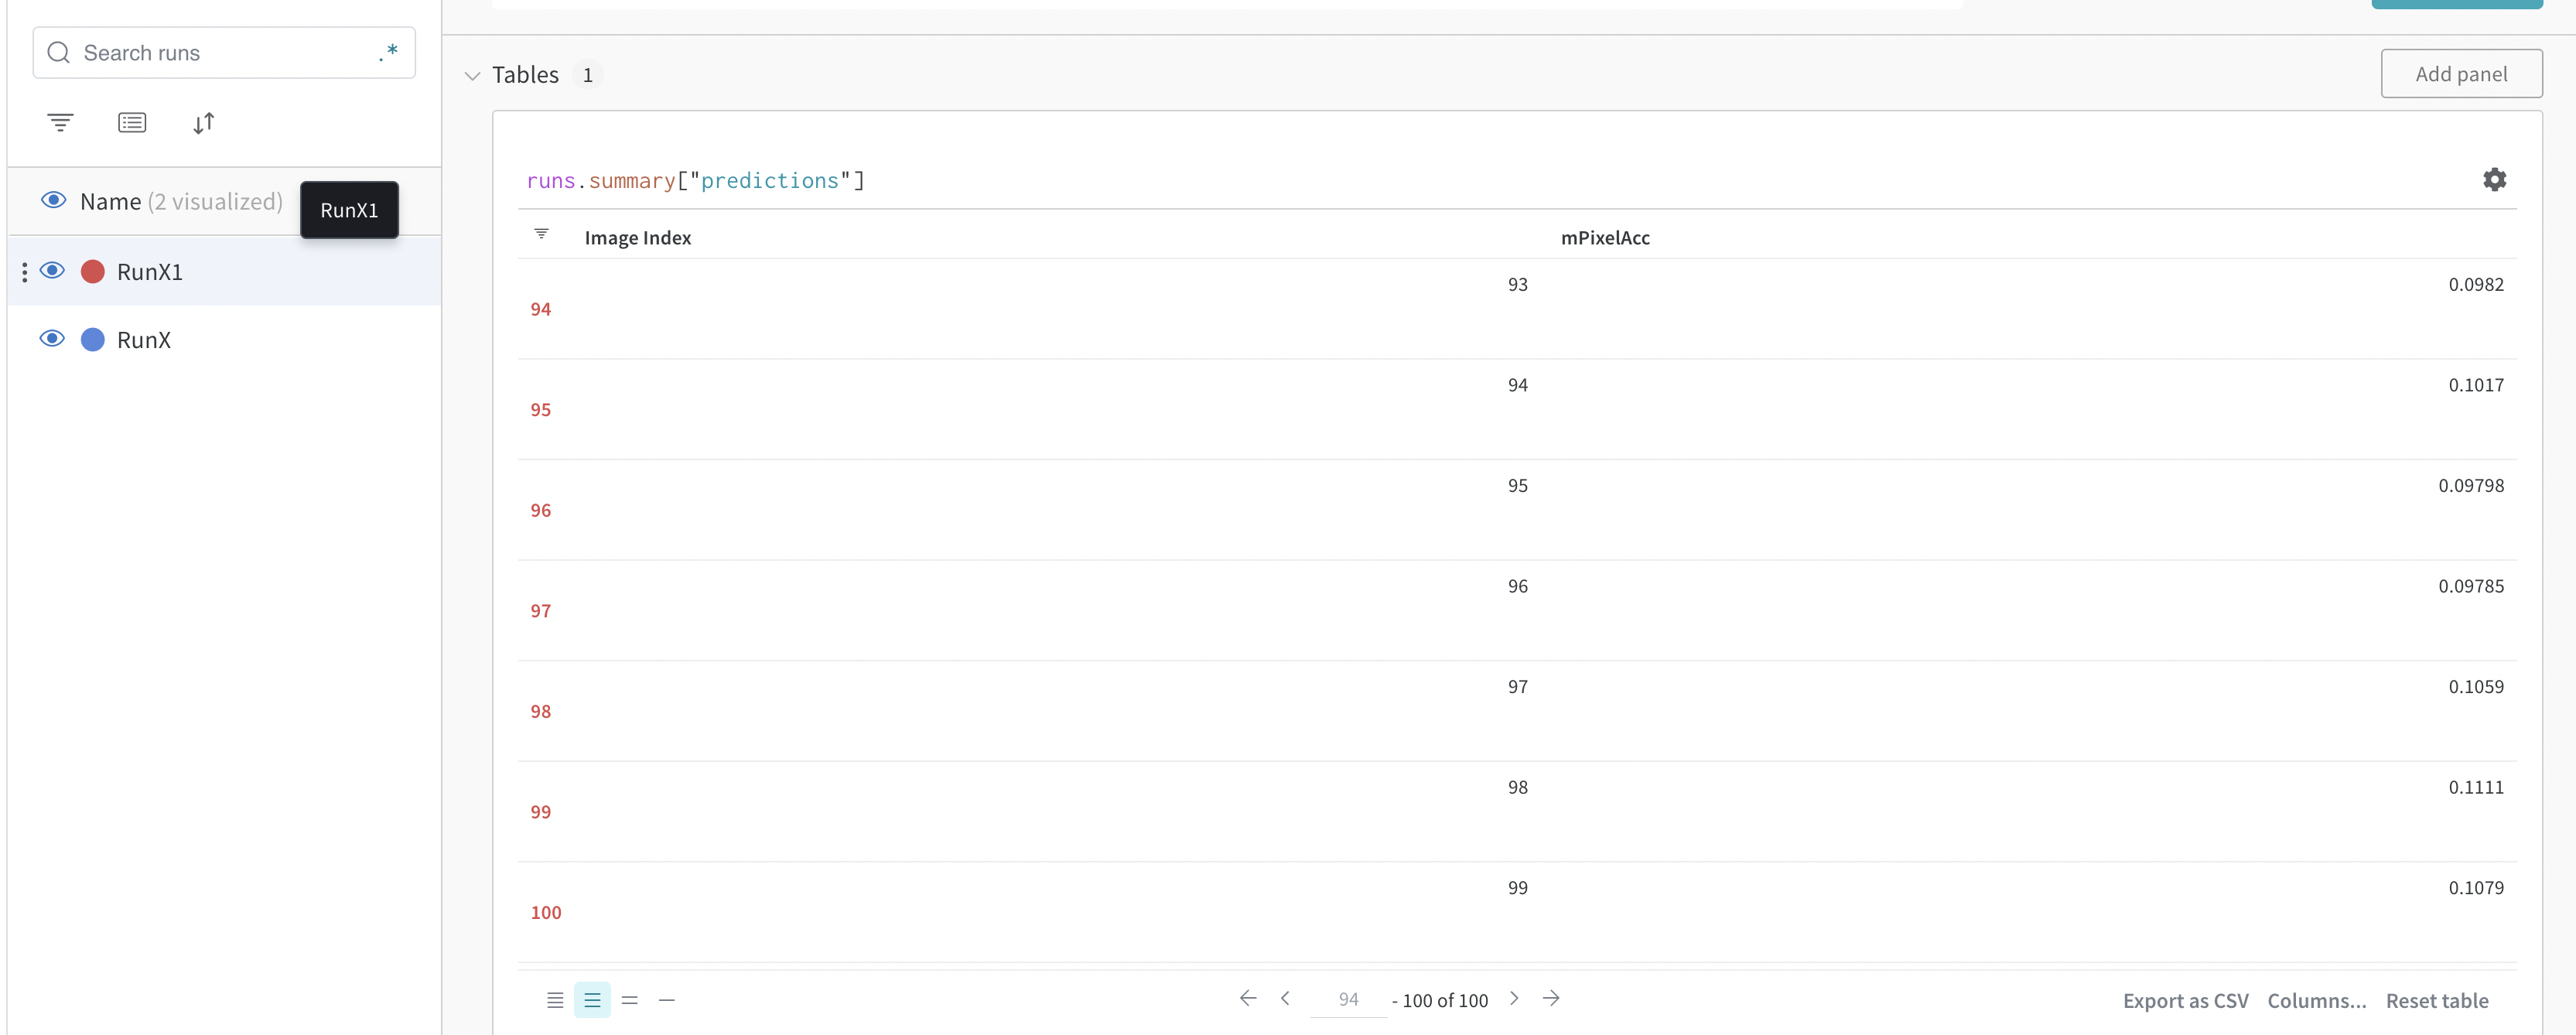

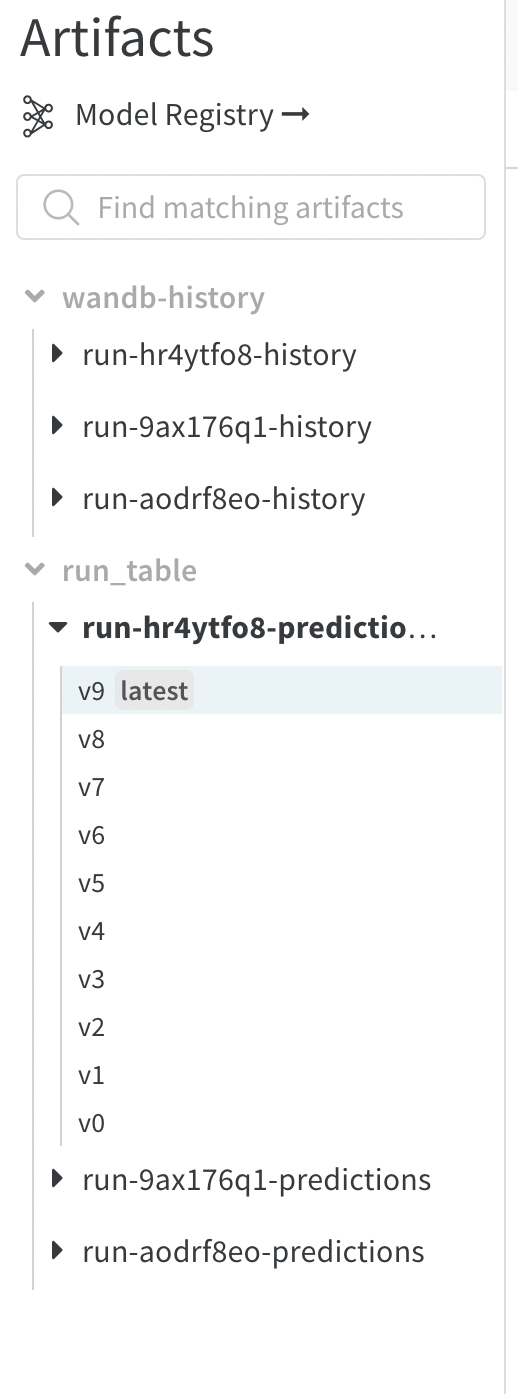

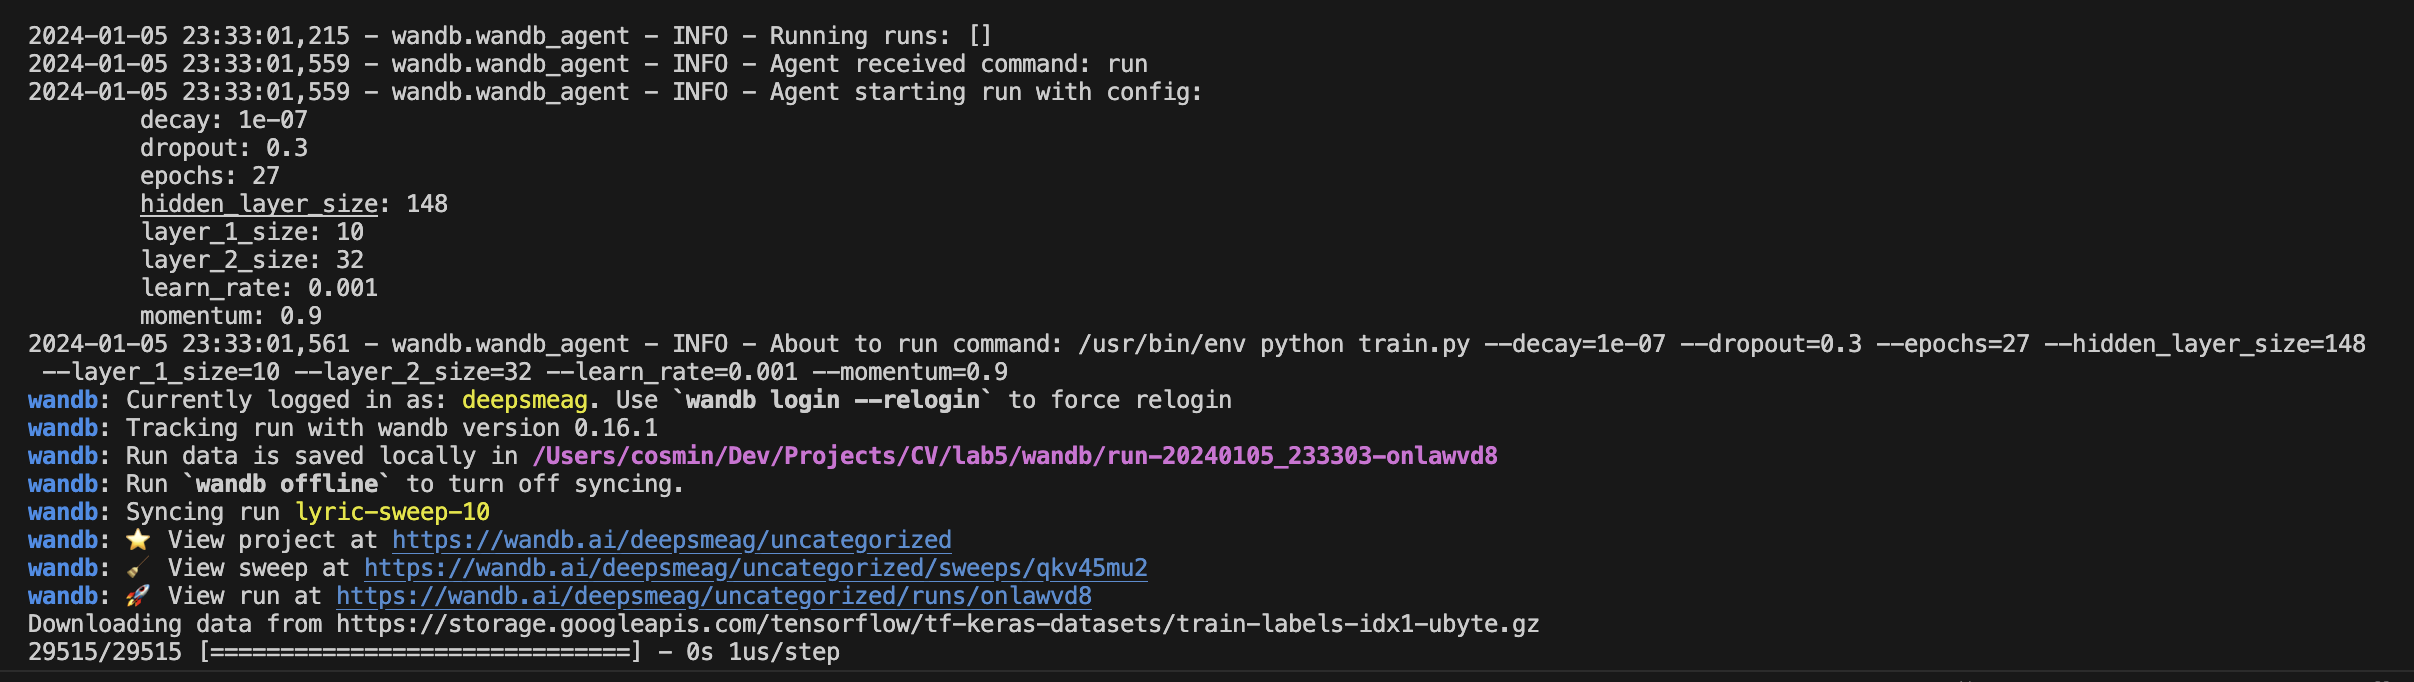

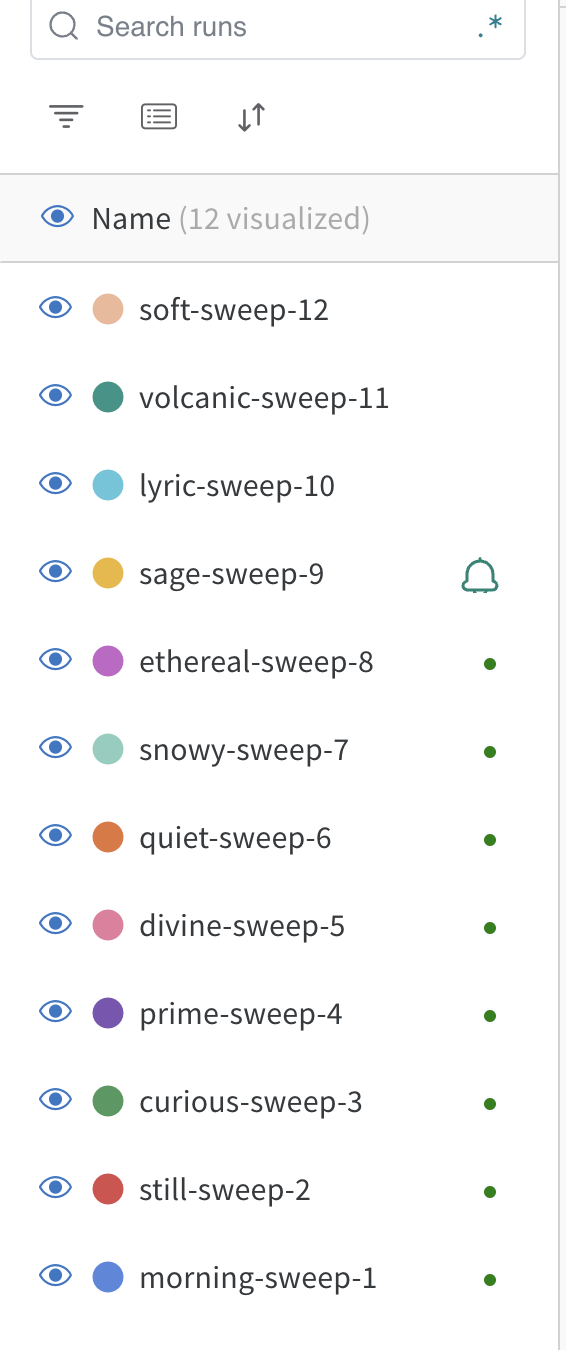

In [15]:
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
import torch

class Block2(Module):
	def __init__(self, inChannels, outChannels):
		super().__init__()
		# store the convolution and RELU layers
		self.conv1 = Conv2d(inChannels, outChannels, 3)
		self.relu = ReLU()
		self.conv2 = Conv2d(outChannels, outChannels, 3)
	def forward(self, x):
		# apply CONV => RELU => CONV block to the inputs and return it
		return self.conv2(self.relu(self.conv1(x)))

class Encoder2(Module):
	def __init__(self, channels=(3, 16, 32, 64)):
		super().__init__()
		self.channels = channels
		self.pool = MaxPool2d(2)
	def forward(self, x):
		# initialize an empty list to store the intermediate outputs
		blockOutputs = []
		x = Block(3,16)(x)
		blockOutputs.append(x)
		x = self.pool(x)
		x = Block(16,32)(x)
		blockOutputs.append(x)
		x = self.pool(x)
		x = Block(32,64)(x)
		blockOutputs.append(x)
		x = self.pool(x)

		
		return blockOutputs

class Decoder2(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		# initialize the number of channels, upsampler blocks, and
		# decoder blocks
		self.channels = channels
		self.upconvs = ModuleList(
			[ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
			 	for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
	def forward(self, x, encFeatures):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)

			
			# crop the current features from the encoder blocks,
			# concatenate them with the current upsampled features,
			# and pass the concatenated output through the current
			# decoder block
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		# return the final decoder output
		return x
	def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		# return the cropped features
		return encFeatures
	
class UNet2(Module):
	def __init__(self, encChannels=(3, 16, 32, 64),
		 decChannels=(64, 32, 16),
		 nbClasses=3, retainDim=True,
		 outSize=(250,  250)):
		super().__init__()
		# initialize the encoder and decoder
		self.encoder = Encoder2(encChannels)
		self.decoder = Decoder2(decChannels)
		# initialize the regression head and store the class variables
		self.head = Conv2d(decChannels[-1], nbClasses, 1)
		self.retainDim = retainDim
		self.outSize = outSize
	def forward(self, x):
		# grab the features from the encoder
		encFeatures = self.encoder(x)
		# pass the encoder features through decoder making sure that
		# their dimensions are suited for concatenation
		decFeatures = self.decoder(encFeatures[::-1][0],
			encFeatures[::-1][1:])
		# pass the decoder features through the regression head to
		# obtain the segmentation mask
		map = self.head(decFeatures)
		# check to see if we are retaining the original output
		# dimensions and if so, then resize the output to match them
		if self.retainDim:
			map = F.interpolate(map, self.outSize)
		# return the segmentation map
		return map

In [17]:



model = UNet()



model.load_state_dict(torch.load('unet.pth'))
scripted_model = torch.jit.script(model)
torch.jit.save(scripted_model, 'unet_scripted.pth')

RuntimeError: Can't redefine method: forward on class: __torch__.___torch_mangle_53.Decoder (of Python compilation unit at: 0x10b7948a8)